In [1]:
save = True

In [2]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from os.path import abspath

In [3]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"

In [4]:
def get_max_score(matrix):
    """
    input: result = out['data'].values matrix (e.g. for distilgpt2 a matrix of dimensions 7x2)
    output: maximum score and associated error for this matrix.
    """
    max_score, error = 0,0
    for i in range(len(matrix)):
        if matrix[i][0] > max_score:
            max_score = matrix[i][0]
            error = matrix[i][1]
    return max_score, error

In [5]:
for filename in os.listdir(working_dir):
    if "same-units" in filename:
        file = os.path.join(working_dir, filename)
        with open(file, 'rb') as f:
            out = pickle.load(f)
s = out['data']
print(s.values)

lang_raw = s.raw.raw
all_raw = s.raw.raw.raw.values
print(lang_raw.shape)

lang = s.raw.raw.values.flatten().tolist()
print(np.unique(lang))
print(np.max(lang_raw.values.flatten()))
print(np.min(lang_raw.values.flatten()))

unique, counts = np.unique(lang_raw.values.flatten(), return_counts=True)
unique, counts

Loading lookup from /om2/user/ckauf/anaconda/envs/perturbedenv/lib/python3.6/site-packages/brainio_collection/lookup.csv
[[nan  0.]]
(1, 13517)
[nan nan nan ... nan nan nan]
nan
nan


(array([nan, nan, nan, ..., nan, nan, nan]), array([1, 1, 1, ..., 1, 1, 1]))

In [6]:
def get_best_scores_df_controlmodels(control_model_list):
    """
    input: model_identifier
    output: dictionary containing the maximum score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    models = []
    max_scores = []
    errors = []
    
    for model_identifier in control_model_list:
        for filename in os.listdir(working_dir):
            if model_identifier in filename:
                print(model_identifier)
                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result = out['data'].values
                print(result, '\n\n')
                max_score, error = get_max_score(result)

                max_scores.append(max_score)
                errors.append(error)
                model_identifier_sub = re.sub(",model=gpt2,","",model_identifier)
                models.append(model_identifier_sub)

    import pandas as pd
    scores_df = pd.DataFrame({'model':models,'score': max_scores,
    'error': errors})
    return scores_df

In [7]:
scores_df = get_best_scores_df_controlmodels(['same-units', 'constant-units', 'length-control,model=gpt2,', 'sentence-length','constant-control,model=gpt2,',  'passage-position','original,model=gpt2,'])
scores_df

same-units
[[nan  0.]] 


constant-units
[[nan  0.]] 


length-control,model=gpt2,
[[ 0.06086905  0.06879403]
 [ 0.02088826  0.0606234 ]
 [ 0.01389273  0.05467721]
 [ 0.03697791  0.05939874]
 [ 0.03480545  0.04030529]
 [-0.00112156  0.03054293]
 [-0.00120238  0.07022093]
 [ 0.00921724  0.05229485]
 [-0.0121605   0.05376402]
 [ 0.01913042  0.04292278]
 [-0.00552017  0.03169919]
 [ 0.03323068  0.0536829 ]
 [-0.00804421  0.04155009]] 


sentence-length
[[0.17663553 0.11095928]] 


constant-control,model=gpt2,
[[0.1360458  0.102507  ]
 [0.12078061 0.14064627]
 [0.16683575 0.13277714]
 [0.1339743  0.14748068]
 [0.14749068 0.11213016]
 [0.1612999  0.11574062]
 [0.1157601  0.09875055]
 [0.13081742 0.12462771]
 [0.14606063 0.09527505]
 [0.12164071 0.12939386]
 [0.12379642 0.08313806]
 [0.14458435 0.0908748 ]
 [0.08926984 0.10043876]] 


passage-position
[[0.25483096 0.09970799]] 


original,model=gpt2,
[[0.01513538 0.04571033]
 [0.56123138 0.1259047 ]
 [0.67228604 0.0755976 ]
 [0.61174773 0.07

,model,score,error
0,same-units,0.000000,0.000000
1,constant-units,0.000000,0.000000
2,length-control,0.060869,0.068794
3,sentence-length,0.176636,0.110959
4,constant-control,0.166836,0.132777
5,passage-position,0.254831,0.099708
6,original,0.844417,0.089327


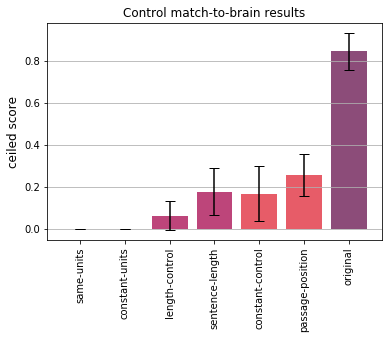

In [8]:
colors = sns.color_palette("rocket")
x_pos = np.arange(len(scores_df))
scores = scores_df['score']
errors = scores_df['error']
models = scores_df['model']

curr_colors = [colors[0]]*2 + [colors[2]]*2 + [colors[3]]*2 + [colors[1]]
fig, ax = plt.subplots()
ax.bar(x_pos, scores,
   yerr=errors,
   align='center',
   alpha=0.8,
   ecolor='black',
   capsize=5,
   color=curr_colors)
ax.set_ylabel('ceiled score',fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(models, rotation=90)
ax.yaxis.grid(True)
plt.title("Control match-to-brain results")
if save:
    savename = "match-to-brain_control_bms_models.png"
    savepath = abspath("../fig")
    plt.savefig(os.path.join(savepath,savename), bbox_inches='tight', dpi=240)
plt.show()

The above figure shows a mix of control benchmarks & control models. Specifically:

* `same-units`: Control model with the same, random unit values for each sentence representation
* `constant-units`: Control model which has a constant unit value (1) for each unit & all sentences
* `length-control`: Benchmark (here: for GPT2-lasttoken), which replaces each word in each sentence by "the"
* `sentence-length`: Control model which represents each sentence as the number of words in it.
* `constant-control`: Benchmark (here: for GPT2-lasttoken), which replaces each sentence by "the."
* `passage-position`: Control model which represents each sentence as its index in the passage
* `original`: GPT2-lasttoken results for Pereira-scrambled-original.

In [9]:
scores_df = get_best_scores_df_controlmodels(['random-wl,model=random-embedding', 'random-wl,model=gpt2,','original,model=gpt2,'])
scores_df

random-wl,model=random-embedding
[[0.02782505 0.10407149]] 


random-wl,model=gpt2,
[[0.06453948 0.04670325]
 [0.44623506 0.07696377]
 [0.49621829 0.10233879]
 [0.36756514 0.09241315]
 [0.32076421 0.07507392]
 [0.28485868 0.09084854]
 [0.35558501 0.05283439]
 [0.35386223 0.08821882]
 [0.4095304  0.05293519]
 [0.42339728 0.02652898]
 [0.47006753 0.08849396]
 [0.53015222 0.0623832 ]
 [0.66203336 0.08560733]] 


original,model=gpt2,
[[0.01513538 0.04571033]
 [0.56123138 0.1259047 ]
 [0.67228604 0.0755976 ]
 [0.61174773 0.07323607]
 [0.47956961 0.10310733]
 [0.49743609 0.0859492 ]
 [0.47568538 0.11072324]
 [0.55793906 0.16824178]
 [0.61512361 0.14229174]
 [0.68892719 0.10718622]
 [0.7124675  0.09231671]
 [0.84441671 0.08932685]
 [0.82698946 0.04830291]] 




,model,score,error
0,"random-wl,model=random-embedding",0.027825,0.104071
1,random-wl,0.662033,0.085607
2,original,0.844417,0.089327


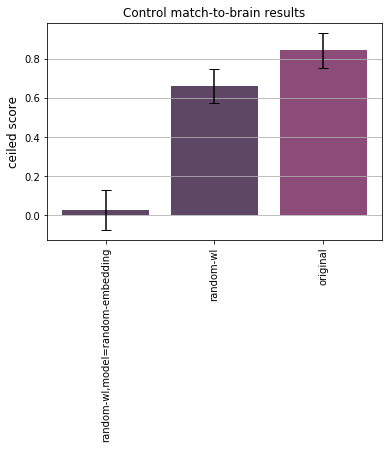

In [10]:
colors = sns.color_palette("rocket")
x_pos = np.arange(len(scores_df))
scores = scores_df['score']
errors = scores_df['error']
models = scores_df['model']

curr_colors = [colors[0]]*2 + [colors[1]]
fig, ax = plt.subplots()
ax.bar(x_pos, scores,
   yerr=errors,
   align='center',
   alpha=0.8,
   ecolor='black',
   capsize=5,
   color=curr_colors)
ax.set_ylabel('ceiled score',fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(models, rotation=90)
ax.yaxis.grid(True)
plt.title("Control match-to-brain results")
if save:
    savename = "match-to-brain_control_random_wl.png"
    savepath = abspath("../fig")
    plt.savefig(os.path.join(savepath,savename), bbox_inches='tight', dpi=240)
plt.show()

# check for different split_coordinate

In [11]:
model_list = [elm for elm in os.listdir(working_dir) if "passagesplit" in elm]

In [12]:
scores_df = get_best_scores_df_controlmodels(model_list)
scores_df

benchmark=Pereira2018-encoding-perturb-functionwords-passagesplit,model=distilgpt2,subsample=None.pkl
[[0.90795852 0.05974642]
 [3.01938117 0.02528412]
 [3.06158347 0.0096182 ]
 [3.05636474 0.01232238]
 [2.71830191 0.21962195]
 [2.73328286 0.16445892]
 [3.0571076  0.02364063]] 


benchmark=Pereira2018-encoding-perturb-nouns-passagesplit,model=distilgpt2,subsample=None.pkl
[[0.97061695 0.06991569]
 [3.094139   0.01028386]
 [3.11419372 0.00921812]
 [3.11393548 0.00621593]
 [3.10777733 0.01074182]
 [3.10419306 0.01338628]
 [3.1038096  0.01644528]] 


benchmark=Pereira2018-encoding-perturb-random-nouns-passagesplit,model=distilgpt2,subsample=None.pkl
[[0.97008045 0.10187023]
 [3.10025247 0.01317694]
 [3.10726035 0.00601885]
 [3.11067918 0.00747641]
 [3.1096969  0.0078107 ]
 [3.1028526  0.01164038]
 [3.10658747 0.00700705]] 


benchmark=Pereira2018-encoding-perturb-sentenceshuffle_passage-passagesplit,model=distilgpt2,subsample=None.pkl
[[1.31812258 0.14365459]
 [3.098827   0.01093676]
 [3.

,model,score,error
0,benchmark=Pereira2018-encoding-perturb-functio...,3.061583,0.009618
1,benchmark=Pereira2018-encoding-perturb-nouns-p...,3.114194,0.009218
2,benchmark=Pereira2018-encoding-perturb-random-...,3.110679,0.007476
3,benchmark=Pereira2018-encoding-perturb-sentenc...,3.112222,0.007958
4,benchmark=Pereira2018-encoding-perturb-sentenc...,3.108372,0.011345
5,benchmark=Pereira2018-encoding-scrambled-origi...,3.114216,0.007675
6,benchmark=Pereira2018-encoding-scrambled-rando...,3.110262,0.012020
7,benchmark=Pereira2018-encoding-scrambled7-pass...,3.114287,0.007756


Text(0.5, 1.0, 'Control match-to-brain results | split_coordinate = passage_index')

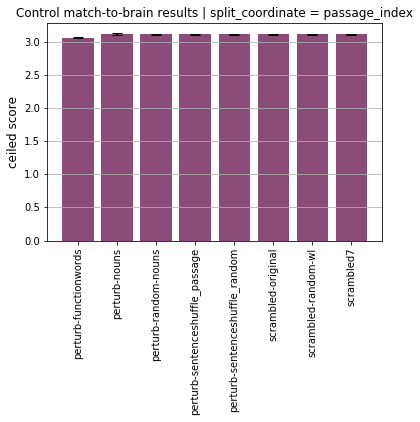

In [13]:
colors = sns.color_palette("rocket")
x_pos = np.arange(len(scores_df))
scores = scores_df['score']
errors = scores_df['error']
models = scores_df['model']

models = [re.sub("benchmark=Pereira2018-encoding-","",elm) for elm in models]
models = [re.sub("-passagesplit,model=distilgpt2,subsample=None.pkl","",elm) for elm in models]

curr_colors = [colors[0]]*2 + [colors[2]]*2 + [colors[3]]*2 + [colors[1]]
fig, ax = plt.subplots()
ax.bar(x_pos, scores,
   yerr=errors,
   align='center',
   alpha=0.8,
   ecolor='black',
   capsize=5,
   color=colors[1])
ax.set_ylabel('ceiled score',fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(models, rotation=90)
ax.yaxis.grid(True)
plt.title("Control match-to-brain results | split_coordinate = passage_index")

In [14]:
models

['perturb-functionwords',
 'perturb-nouns',
 'perturb-random-nouns',
 'perturb-sentenceshuffle_passage',
 'perturb-sentenceshuffle_random',
 'scrambled-original',
 'scrambled-random-wl',
 'scrambled7']

# Passage_index as split_coord

In [15]:
model_list = [elm for elm in os.listdir(working_dir) if "topicsplit" in elm]
scores_df = get_best_scores_df_controlmodels(model_list)
scores_df

benchmark=Pereira2018-encoding-scrambled-original-topicsplit,model=distilgpt2,subsample=None.pkl
[[1.38848158e+00 5.89635708e-02]
 [3.13905751e+00 4.76980678e-09]
 [3.13905752e+00 3.38111182e-10]
 [3.13905752e+00 2.55865366e-10]
 [3.13905752e+00 3.14545281e-11]
 [3.13905752e+00 7.04334140e-11]
 [3.13905750e+00 8.59077279e-09]] 


benchmark=Pereira2018-encoding-scrambled-random-wl-topicsplit,model=distilgpt2,subsample=None.pkl
[[1.36564647e+00 1.19023907e-01]
 [3.13905750e+00 1.03632952e-08]
 [3.13905752e+00 2.94415913e-10]
 [3.13905752e+00 1.97550237e-11]
 [3.13905752e+00 5.04799798e-11]
 [3.13905752e+00 2.59788625e-11]
 [3.13905751e+00 3.89623982e-09]] 




,model,score,error
0,benchmark=Pereira2018-encoding-scrambled-origi...,3.139058,3.145453e-11
1,benchmark=Pereira2018-encoding-scrambled-rando...,3.139058,1.975502e-11


Text(0.5, 1.0, 'Control match-to-brain results | split_coordinate = passage_category')

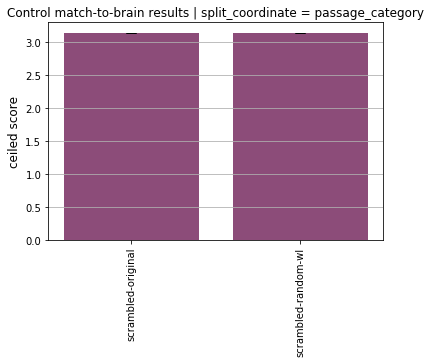

In [16]:
colors = sns.color_palette("rocket")
x_pos = np.arange(len(scores_df))
scores = scores_df['score']
errors = scores_df['error']
models = scores_df['model']

models = [re.sub("benchmark=Pereira2018-encoding-","",elm) for elm in models]
models = [re.sub("-topicsplit,model=distilgpt2,subsample=None.pkl","",elm) for elm in models]

curr_colors = [colors[0]]*2 + [colors[2]]*2 + [colors[3]]*2 + [colors[1]]
fig, ax = plt.subplots()
ax.bar(x_pos, scores,
   yerr=errors,
   align='center',
   alpha=0.8,
   ecolor='black',
   capsize=5,
   color=colors[1])
ax.set_ylabel('ceiled score',fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(models, rotation=90)
ax.yaxis.grid(True)
plt.title("Control match-to-brain results | split_coordinate = passage_category")